# Идентификация пользователя:Финальный отчёт

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".

Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать.

Имеются данные с прокси-серверов Университета Блеза Паскаля, они имеют очень простой вид. Для каждого пользователя заведен csv-файл с названием user\*\*\*\*.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате: <br>

<center>*timestamp, посещенный веб-сайт*</center>


Импортируем необходимые библиотеки:

In [163]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import SGDClassifier,LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack,vstack


In [10]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

И данные:

In [2]:
PATH_TO_DATA = 'capstone_user_identification'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

train_df.sort_values(by='time1', inplace=True)

In [4]:
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

In [131]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), "rb") as file:
        site_dict = pickle.load(file)

Напишем функцию для предобрабоки данных. Значения NaN для сайтов я заменяю на нули.

In [147]:
def raw_to_good (train_df, test_df):
    
    print(train_df.shape, test_df.shape)

    train_df.loc[:, times] = train_df[times].apply(pd.to_datetime)
    test_df.loc[:, times] = test_df[times].apply(pd.to_datetime)

    train_df = feature_engineering(train_df)
    test_df = feature_engineering(test_df)
    
    train_df[sites] = train_df[sites].fillna(0).astype('int')
    test_df[sites] = test_df[sites].fillna(0).astype('int')
    
    print(train_df.shape, test_df.shape)
    
    return train_df, test_df

И напишем функцию для создания признаков,далее поясню по каждому из них

In [146]:
def feature_engineering(data):
    
    data['min'] = data[times].min(axis=1)
    data['max'] = data[times].max(axis=1)
    
    data['session_timespan'] = (data['max'] - data['min']).apply(lambda x: x.total_seconds()).astype('int')
    data['start_hour'] = data['min'].apply(lambda x: x.hour)
    data['day_of_week'] = data['min'].apply(lambda x: x.dayofweek)
    data['start_month'] = data['min'].apply(lambda x: x.month)
    
    data['#unique_sites'] = data[sites].nunique(axis=1)
    
    data['morning'] = ((data['start_hour'] >= 7) & (data['start_hour'] <= 11)).astype('int')
    data['day'] = ((data['start_hour'] >= 12) & (data['start_hour'] <= 18)).astype('int')
    data['evening'] = ((data['start_hour'] >= 19) & (data['start_hour'] <= 23)).astype('int')
    data['night'] = ((data['start_hour'] >= 0) & (data['start_hour'] <= 6)).astype('int')
    
    data['youtube']  = check(data[sites].fillna(0).astype('int').values,youtube_freq)
    data['facebook']  = check(data[sites].fillna(0).astype('int').values,facebook_freq)

    
    return data

In [141]:
youtube_freq=dict([(key,value) for key, value in site_dict.items() if 'youtube' in key.lower()])
facebook_freq=dict([(key,value) for key, value in site_dict.items() if 'facebook' in key.lower()])

def check(sites, freq):
    k=[]
    
    for line in sites:
        ch_arr = [int(site in freq.values()) for site in line]
        k.append(sum(ch_arr)/len([i for i in line if i > 0]))
    
    return k

In [148]:
%%time
train, test = raw_to_good(train_df,test_df)

(253561, 34) (82797, 31)
(253561, 34) (82797, 33)
Wall time: 2min 8s


# Признаки

## #unique_sites
Это признак- количество уникальных сайтов в сессии. Судя по гистограммам- не очень поможет отличить Alice.

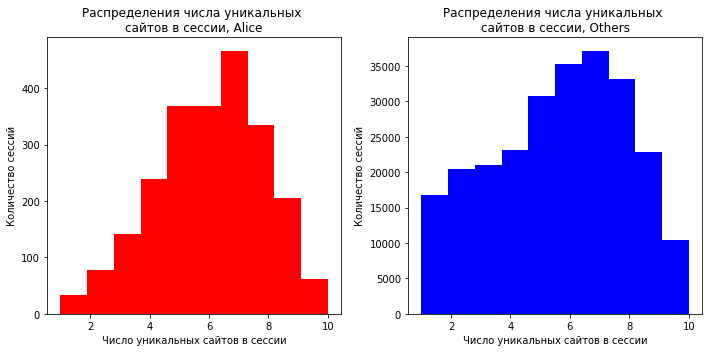

In [184]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['#unique_sites'],color='red')
axes[0].set(xlabel='Число уникальных сайтов в сессии', ylabel='Количество сессий')
axes[0].set_title('Распределения числа уникальных \nсайтов в сессии, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['#unique_sites'],color='blue')
axes[1].set(xlabel='Число уникальных сайтов в сессии', ylabel='Количество сессий')
axes[1].set_title('Распределения числа уникальных \nсайтов в сессии, Others')

plt.tight_layout()

## session_timespan
Следующий признак - session_timespan - длина сессии в секундах. По гитограмме-тоже не очень(

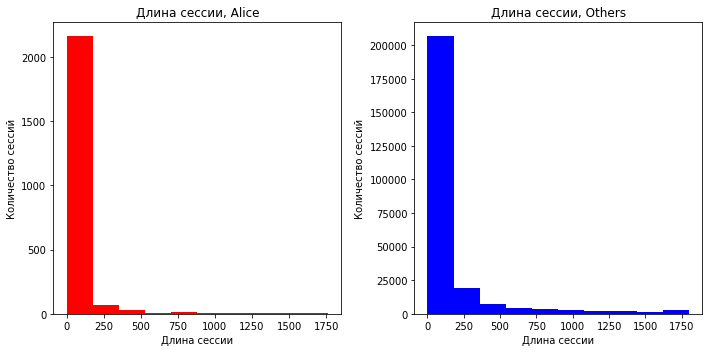

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['session_timespan'],color='red')
axes[0].set(xlabel='Длина сессии', ylabel='Количество сессий')
axes[0].set_title('Длина сессии, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['session_timespan'],color='blue')
axes[1].set(xlabel='Длина сессии', ylabel='Количество сессий')
axes[1].set_title('Длина сессии, Others')

plt.tight_layout()

## start_hour
start_hour  - час начала сесиии. Судя по всему -  очень хороший признак, отличия прекрасно видны.

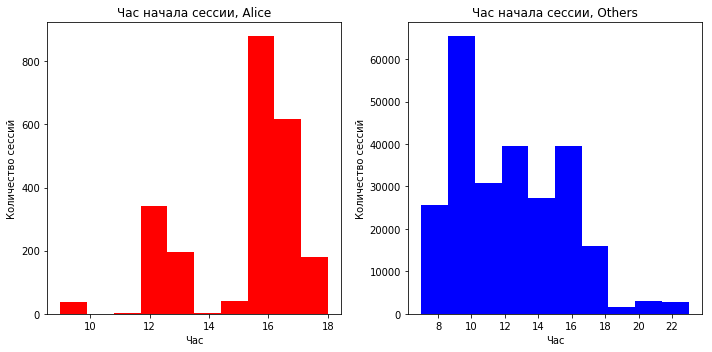

In [196]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['start_hour'],color='red')
axes[0].set(xlabel='Час', ylabel='Количество сессий')
axes[0].set_title('Час начала сессии, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['start_hour'],color='blue')
axes[1].set(xlabel='Час', ylabel='Количество сессий')
axes[1].set_title('Час начала сессии, Others')

plt.tight_layout()

## day_of_week
day_of_week - день начала сессии. Этот признак тоже возможно использовать.

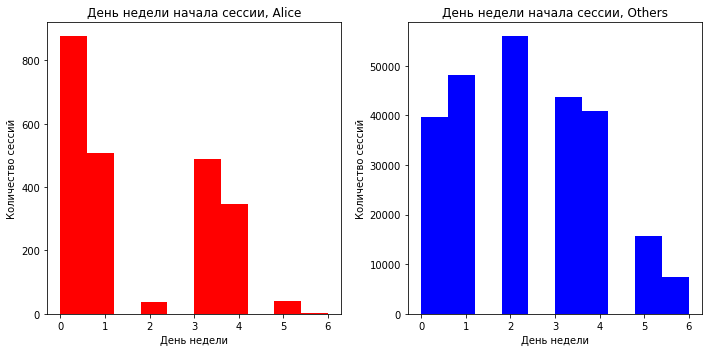

In [197]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['day_of_week'],color='red')
axes[0].set(xlabel='День недели', ylabel='Количество сессий')
axes[0].set_title('День недели начала сессии, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['day_of_week'],color='blue')
axes[1].set(xlabel='День недели', ylabel='Количество сессий')
axes[1].set_title('День недели начала сессии, Others')

plt.tight_layout()

## start_month
start_month - месяц начала сессии

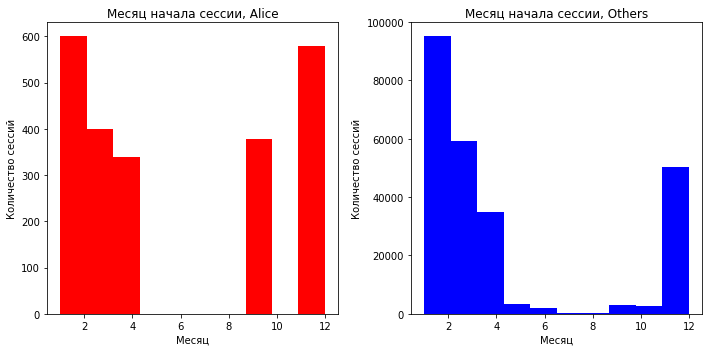

In [198]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['start_month'],color='red')
axes[0].set(xlabel='Месяц', ylabel='Количество сессий')
axes[0].set_title('Месяц начала сессии, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['start_month'],color='blue')
axes[1].set(xlabel='Месяц', ylabel='Количество сессий')
axes[1].set_title('Месяц начала сессии, Others')



## facebook
facebook - доля фейсбука в сессии (проще говоря, количество сайтов с facebook в названии, делённое на длину сессии). 

Честно говоря, этот признак не очень)

Text(0.5,1,'facebook, Others')

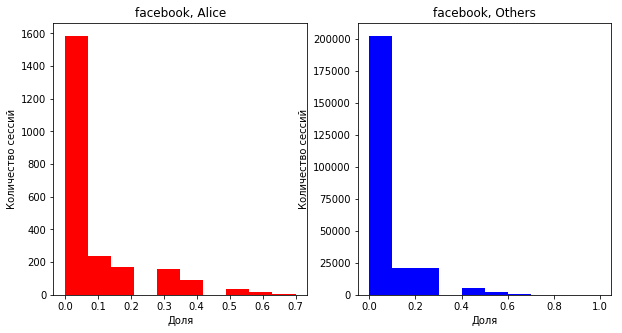

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['facebook'],color='red')
axes[0].set(xlabel='Доля', ylabel='Количество сессий')
axes[0].set_title('facebook, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['facebook'],color='blue')
axes[1].set(xlabel='Доля', ylabel='Количество сессий')
axes[1].set_title('facebook, Others')


## youtube
youtube - аналогичен признаку facebook, но с сайтами с youtube в названии. Здесь уже шансы получше.

Text(0.5,1,'youtube, Others')

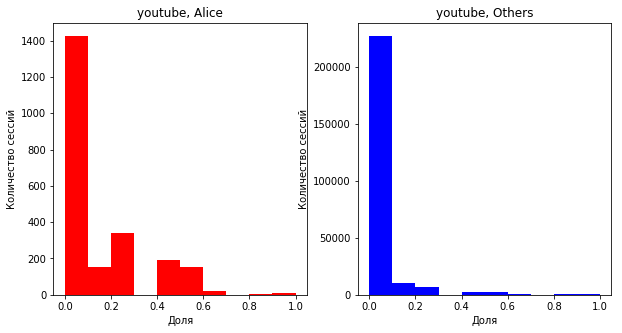

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.ravel()

axes[0].hist(train_test_df[train_test_df.target == 1]['youtube'],color='red')
axes[0].set(xlabel='Доля', ylabel='Количество сессий')
axes[0].set_title('youtube, Alice')

axes[1].hist(train_test_df[train_test_df.target == 0]['youtube'],color='blue')
axes[1].set(xlabel='Доля', ylabel='Количество сессий')
axes[1].set_title('youtube, Others')


## morning, day, evening, night
Эти признаки показывают, когда началась сессия. 

# Модели
Теперь непосредственно к моделям. Их было сделано всего две.
## LogisticRegression без трансформации данных
Модель обучалась на данных - номера  сайтов и различные признаки, предварительно преобразованных в формат разреженной матрицы. Кроссс - валидация - StratifiedKFold с тремя фолдами. Оценивалась ROC AUC по кросс-валидации и валидационной выборке. После этого подбирался гиперпараметр. В принципе, ничего особенного и выдающегося.

In [151]:
train_test_df = pd.concat([train, test])
train_test_df_sites = train_test_df[sites]

In [11]:
def to_dense(X):
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for i in np.array(X.as_matrix()):
        for j in i:
            index = vocabulary.setdefault(j, len(vocabulary))
            indices.append(j)
            data.append(1)
        indptr.append(len(indices))
    
    
    X_sparse = csr_matrix((data, indices, indptr), dtype=int)[:, 1:]
    
    return  X_sparse

In [112]:
def training(train,test,features):
    
    train_test_df = pd.concat([train, test])
    train_test_df_features = train_test_df[features]
    
    train_test_sparse = to_dense(train_test_df_features)
    
    X_train_sparse = train_test_sparse[:train.shape[0],:]
    X_test_sparse = train_test_sparse[train.shape[0]:,:]
    
    y = train.target.as_matrix()

    
    train_share = int(.7 * X_train_sparse.shape[0])
    
    X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
    X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

    
    
    logit = LogisticRegression()
    
    time_split = TimeSeriesSplit(n_splits=10)
    skf = StratifiedKFold(n_splits=3)
    
    params = {'C': np.linspace(0.00001, 2, 10)}
    
    logit_grid = GridSearchCV(estimator=logit, param_grid=params,
                          scoring='roc_auc', n_jobs=-1,
                          cv=skf)
    logit_grid.fit(X_train, y_train)

    #print('ROC AUC score: ', logit_grid.best_score_)

    a = logit_grid.best_estimator_
    a.fit(X_train, y_train)
    
    val_score = roc_auc_score( y_valid, a.predict_proba(X_valid)[:, 1])
    
    print('Valid score: ',val_score)

    a.fit(X_train_sparse, y)
    result  = a.predict_proba(X_test_sparse)

    
    return val_score, result

In [153]:
%%time
features = ['site' + str(i) for i in range(1,11)] +\
           ['youtube']#['morning','day','evening','night']
scr, result = training(train, test, features)

Valid score:  0.8798697434526108
Wall time: 1min 36s


In [ ]:
write_to_submission_file(result[:,1], 'start_hour.csv')

### Результаты на валидационной выборке для различных признаков


Sites +'session_timespan', '#unique_sites', 'start_hour', 'day_of_week','start_month'   0.926763947844081 

only sites  0.8800871645143995

Sites +'session_timespan'  0.87918673242056

Sites +'unique_sites'   0.8795062393617561

Sites +'start_hour'  0.9477759133274511

Sites +'day_of_week'  0.90114990321952

Sites +'start_month'  0.8692979826535584

Sites +'session_timespan', '#unique_sites', 'start_hour', 'day_of_week','start_month' + daytimes 0.9256392334422704

'youtube'   0.8798697434526108

'facebook'   0.8799271697172114


## LogisticRegression с преобразованием CountVectorizer
Последовательность сайтов в сессии мы воспринимаем как bag of words,с максимальным количеством признаков 50000,векторизуем, и прилепляем затем к преобразованным данным признаки.  Кросс-валидация - TimeSeriesSplit с десятью разбиениями. Оценивалась по ROC AUC на кросс-валидации.

In [169]:
def training_withCV(train,test,features):

    
    y = train.target.astype('int').values

    cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
    
    train[sites].to_csv('train.txt', sep=' ', index=None, header=None)
    test[sites].to_csv('test.txt', sep=' ', index=None, header=None)

    
    with open('train.txt') as inp_train_file:
        X_trainCV = cv.fit_transform(inp_train_file)
    
    with open('test.txt') as inp_test_file:
        X_testCV = cv.transform(inp_test_file)

    X_trainCV = hstack([X_trainCV,train[features].values])
    X_testCV = hstack([X_testCV,test[features].values])
    
    
    
    logit = LogisticRegression( solver='liblinear')
    time_split = TimeSeriesSplit(n_splits=10)
    
    params = {'C': np.logspace(-2, 2, 10)}
    
    logit_grid = GridSearchCV(estimator=logit, param_grid=params,
                          scoring='roc_auc', n_jobs=-1,
                          cv=time_split)
    print('-------------')
    logit_grid.fit(X_trainCV, y)
    
    print(logit_grid.best_score_, logit_grid.best_params_)


    a = logit_grid.best_estimator_
    
    result  = a.predict_proba(X_testCV)

    return logit_grid.best_score_, result

In [172]:
%%time

features = ['youtube','day_of_week' , 'start_hour','morning','day','evening','night'] #['day_of_week' , 'start_hour','morning','day','evening','night']

scrCV, resultCV = training_withCV(train, test, features)

-------------
0.9198687588277933 {'C': 0.21544346900318834}
Wall time: 16min 34s


0.9168257997568604 {'C': 0.21544346900318834}


In [173]:
write_to_submission_file(resultCV[:,1], 'TRY.csv')

### Результаты на кросс - валидации и гиперпараметры для различных признаков

Only sites (0.8706696528484077, {'C': 0.21544346900318834})

'start_hour' (0.9029250810074426 {'C': 0.5994842503189409}

'start_hour', 'day_of_week'   0.9013968026848076 {'C': 0.5994842503189409}

'morning','day','evening','night' 0.9173773731531685 {'C': 0.21544346900318834}

'session_timespan', '#unique_sites', 'start_hour', 'day_of_week','start_month','morning','day','evening','night'  0.9142997237171296 {'C': 0.21544346900318834}

'day_of_week' , 'start_hour','morning','day','evening','night' 0.9168316533015023 {'C': 0.21544346900318834}

# Выводы
Модель с трансформацией данных показала себя несомненно лучше. Конечно, итоговый результат не самый крутой, но ничего страшного)

Лучший мой результат - 0.94494 на метрике ROC_AUC, 1528 место. Как мне кажется, такое решение имеет прикладное применение для детекции пользователя.

### Что не удалось:
- Трансформировать данные не только через CountVecorizer
- Применить другие модели
- Обучить модель на большем количестве данных

### С чем поработал и чему научился:
- Предобрабатывать данные,особенно в datetime формате
- Применять кросс-валидацию и логистическую регрессию
- Посоставлял разные признаки для задачи
- Узнал про разреженный формат матриц

##  Вам спасибо за проверку, а создателям спасибо за курс ;)